# 初始化

In [0]:
#@markdown - **挂载** 
from google.colab import drive
drive.mount('GoogleDrive')

In [0]:
# #@markdown - **卸载**
# !fusermount -u GoogleDrive

# 代码区

In [0]:
#@title 随机森林 { display-mode: "both" }
#@markdown [参考程序](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/2_BasicModels/random_forest.ipynb)
# Random forest
import tensorflow as tf
from tensorflow.python.ops import resources
from tensorflow.contrib.tensor_forest.python import tensor_forest
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [0]:
#@markdown - **绑定数据**
class Bunch(dict):  
	def __init__(self,*args,**kwds):  
		super(Bunch,self).__init__(*args,**kwds)  
		self.__dict__ = self

In [0]:
#@markdown - **生成带标签的随机数据**
def generate_random(sigma, N, mu1=[15., 25., 10], mu2=[30., 40., 30], mu3=[25., 10., 20], mu4=[40., 30., 40]):  
	c = sigma.shape[-1]        #生成N行c维的随机测试数据，比较kmeans与decision tree
	X = np.zeros((N, c))       # 初始化X，2行N列。2维数据，N个样本 
	target = np.zeros((N,1))
	for i in range(N):  
		if np.random.random(1) < 0.25:  # 生成0-1之间随机数  
			X[i, :]  = np.random.multivariate_normal(mu1, sigma[0, :, :], 1)     #用第一个高斯模型生成2维数据  
			target[i] = 0
		elif 0.25 <= np.random.random(1) < 0.5:  
			X[i, :] = np.random.multivariate_normal(mu2, sigma[1, :, :], 1)      #用第二个高斯模型生成2维数据  
			target[i] = 1
		elif 0.5 <= np.random.random(1) < 0.75:  
			X[i, :] = np.random.multivariate_normal(mu3, sigma[2, :, :], 1)      #用第三个高斯模型生成2维数据  
			target[i] = 2
		else:  
			X[i, :] = np.random.multivariate_normal(mu4, sigma[3, :, :], 1)      #用第四个高斯模型生成2维数据  
			target[i] = 3
	return X, target

In [0]:
#@markdown - **生成训练、测试集数据**
k, N = 4, 400
sigma = np.zeros((k, 3, 3))
for i in range(k):
	sigma[i, :, :] = np.diag(np.random.randint(10, 25, size=(3, )))
sample, target = generate_random(sigma, N)
feature_names = ['x_label', 'y_label', 'z_label'] # 特征数
target_names = ['gaussian1', 'gaussian2', 'gaussian3', 'gaussian4'] # 类别
data = Bunch(sample=sample, feature_names=feature_names, target=target, target_names=target_names)
sample_t, target_t = generate_random(sigma, N)
data_t = Bunch(sample=sample_t, target=target_t)

In [0]:
#@markdown - **模型参数设置**
num_steps = 20 #@param {type: "integer"}
batch_size = 256 #@param {type: "integer"}
num_classes = 4 #@param {type: "integer"}
num_features = 3 #@param {type: "integer"}
num_trees = 5 #@param {type: "integer"}
max_nodes = 20 #@param {type: "integer"}

# Input and Target data
X = tf.placeholder(tf.float32, shape=[None, num_features])
# For random forest, labels must be integers (the class id)
Y = tf.placeholder(tf.int32, shape=[None])

# Random Forest Parameters
hparams = tensor_forest.ForestHParams(num_classes=num_classes,
                                      num_features=num_features,
                                      num_trees=num_trees,
                                      max_nodes=max_nodes).fill()


In [8]:
#@markdown - **RF 的图模型**
forest_graph = tensor_forest.RandomForestGraphs(hparams)
train_op = forest_graph.training_graph(X, Y)
loss_op = forest_graph.training_loss(X, Y)

# 正确率
infer_op, _, _ = forest_graph.inference_graph(X)
correct_prediction = tf.equal(tf.argmax(infer_op, 1), tf.cast(Y, tf.int64))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 初始化
init_vars = tf.group(tf.global_variables_initializer(),
    resources.initialize_resources(resources.shared_resources()))

INFO:tensorflow:Constructing forest with params = 
INFO:tensorflow:{'num_trees': 5, 'max_nodes': 20, 'bagging_fraction': 1.0, 'feature_bagging_fraction': 1.0, 'num_splits_to_consider': 10, 'max_fertile_nodes': 0, 'split_after_samples': 250, 'valid_leaf_threshold': 1, 'dominate_method': 'bootstrap', 'dominate_fraction': 0.99, 'model_name': 'all_dense', 'split_finish_name': 'basic', 'split_pruning_name': 'none', 'collate_examples': False, 'checkpoint_stats': False, 'use_running_stats_method': False, 'initialize_average_splits': False, 'inference_tree_paths': False, 'param_file': None, 'split_name': 'less_or_equal', 'early_finish_check_every_samples': 0, 'prune_every_samples': 0, 'num_classes': 4, 'num_features': 3, 'bagged_num_features': 3, 'bagged_features': None, 'regression': False, 'num_outputs': 1, 'num_output_columns': 5, 'base_random_seed': 0, 'leaf_model_type': 0, 'stats_model_type': 0, 'finish_type': 0, 'pruning_type': 0, 'split_type': 0}
Instructions for updating:
Colocations h

In [9]:
#@markdown - **设置会话**
sess = tf.train.MonitoredSession()

sess.run(init_vars)

#@markdown - **训练模型**
for i in range(1, num_steps + 1):
    batch_data = np.c_[data.sample, data.target]
    np.random.shuffle(batch_data)
    batch_x, batch_y = batch_data[:batch_size, :-1], batch_data[:batch_size, -1]
    _, l, acc = sess.run([train_op, loss_op, accuracy_op], feed_dict={X: batch_x, Y: batch_y})
    acc *= 100
    print_list = [i, l, acc]
    print('Step {0[0]}, loss: {0[1]:.4f}, accuracy: {0[2]:.2f}%.'.format(print_list))
# 训练集
acc, pre_train = sess.run([accuracy_op, infer_op], feed_dict={X: data.sample, Y: data.target.flatten()})
acc *= 100
print('Accuracy on training set: %.2f.' % acc)
# 测试集
test_x, test_y = data_t.sample, data_t.target.flatten()
acc_t, pre_test = sess.run([accuracy_op, infer_op], feed_dict={X: test_x, Y: test_y})
acc_t *= 100
print('Accuracy on testing set: %.2f.' % acc_t)

sess.close()

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Step 1, loss: -1.0000, accuracy: 38.67%.
Step 2, loss: -1.0000, accuracy: 68.36%.
Step 3, loss: -3.0000, accuracy: 67.58%.
Step 4, loss: -3.0000, accuracy: 83.59%.
Step 5, loss: -5.0000, accuracy: 85.16%.
Step 6, loss: -5.8000, accuracy: 85.16%.
Step 7, loss: -7.0000, accuracy: 87.89%.
Step 8, loss: -9.0000, accuracy: 95.31%.
Step 9, loss: -10.2000, accuracy: 96.48%.
Step 10, loss: -11.0000, accuracy: 95.70%.
Step 11, loss: -12.2000, accuracy: 96.48%.
Step 12, loss: -13.8000, accuracy: 97.27%.
Step 13, loss: -14.2000, accuracy: 97.66%.
Step 14, loss: -15.0000, accuracy: 97.66%.
Step 15, loss: -15.8000, accuracy: 97.66%.
Step 16, loss: -17.0000, accuracy: 98.44%.
Step 17, loss: -17.0000, accuracy: 98.44%.
Step 18, loss: -19.0000, accuracy: 99.61%.
Step 19, loss: -19.0000, accuracy: 98.05%.
Step 20, loss: -20.6000, accuracy: 98.44%.
Accuracy on training set: 98.75.
Accu

In [0]:
target_train = data.target.flatten().astype('int32')
target_pre = np.argmax(pre_train, axis=1).astype('int32')

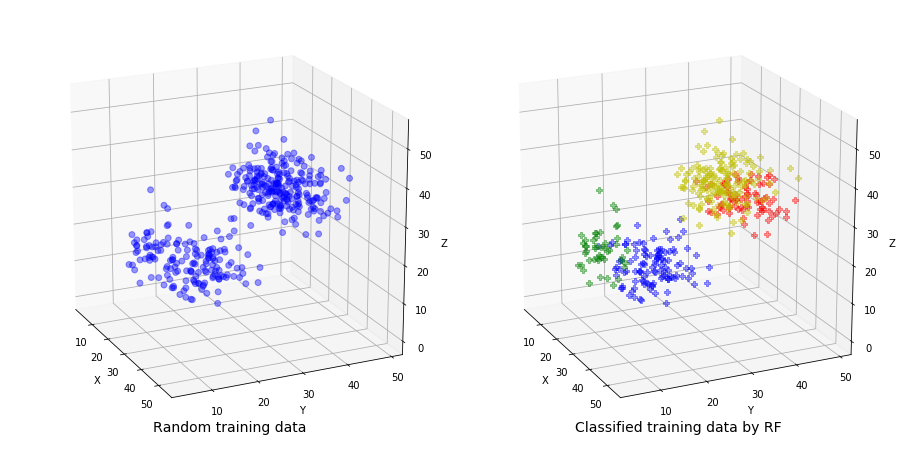

In [11]:
#@markdown - **显示训练，测试数据的分布**
titles = ['Random training data', 'Classified training data by RF']
TAR = [target_train, target_pre]
DATA = [data.sample, data.sample]
fig = plt.figure(1, figsize=(16, 8))
fig.subplots_adjust(wspace=.01, hspace=.02)
for i, title, data_n, tar in zip([1, 2], titles, DATA, TAR):
    ax = fig.add_subplot(1, 2, i, projection='3d')
    if title == 'Random training data':
        ax.scatter(data_n[:,0], data_n[:,1], data_n[:,2], c='b', s=35, alpha=0.4, marker='o')
    else:
        color=['b','r','g','y']
        for j in range(N):
            ax.scatter(data_n[j, 0], data_n[j, 1], data_n[j, 2], c=color[tar[j]], s=35, alpha=0.4, marker='P')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=20., azim=-25)
    ax.set_title(title, fontsize=14, y=0.01)
plt.show()

In [0]:
target_test = data_t.target.flatten().astype('int32')
target_pre = np.argmax(pre_test, axis=1).astype('int32')

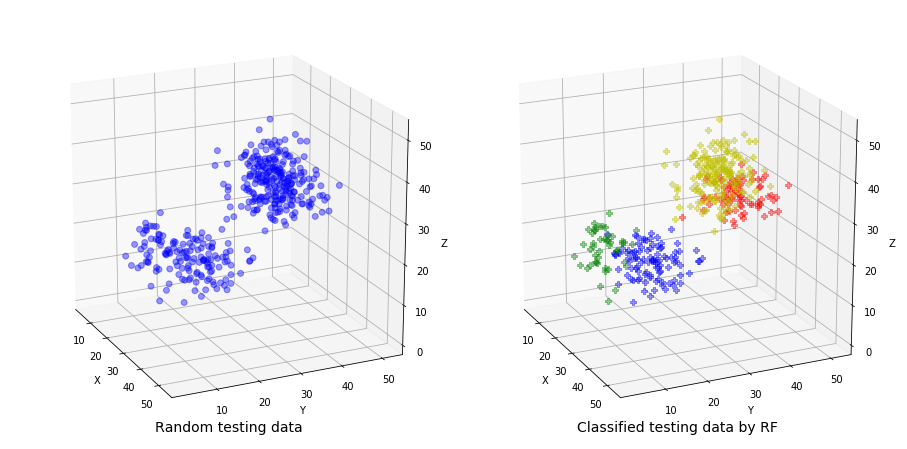

In [13]:
#@markdown - **显示 RF 对测试数据的分类情况**
titles = ['Random testing data', 'Classified testing data by RF']
TAR = [target_test, target_pre]
DATA = [data_t.sample, data_t.sample]
fig = plt.figure(2, figsize=(16, 8))
fig.subplots_adjust(wspace=.01, hspace=.02)
for i, title, data_n, tar in zip([1, 2], titles, DATA, TAR):
    ax = fig.add_subplot(1, 2, i, projection='3d')
    if title == 'Random testing data':
        ax.scatter(data_n[:,0], data_n[:,1], data_n[:,2], c='b', s=35, alpha=0.4, marker='o')
    else:
        color=['b','r','g','y']
        for j in range(N):
            ax.scatter(data_n[j, 0], data_n[j, 1], data_n[j, 2], c=color[tar[j]], s=35, alpha=0.4, marker='P')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=20., azim=-25)
    ax.set_title(title, fontsize=14, y=0.01)
plt.show()